In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import copy
import random
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from pylab import mpl
import seaborn as sns
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
from scipy import stats
from scipy.stats import norm, skew
pd.options.display.max_columns = None

In [2]:
path = '../data/'
train = pd.read_csv(path+'train_dataset.csv')
test = pd.read_csv(path+'test_dataset.csv')
full_data = pd.concat([train,test],axis=0)

D:\myWorkSoftware\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [3]:
train

,用户编码,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
0,a4651f98c82948b186bdcdc8108381b4,1,44,0,0,0,186,1,99.80,163.86,159.20,180,0,3,83,1,75,0,0,0,1,1,713,0,2740,7145,0,0,30,664
1,aeb10247db4e4d67b2550bbc42ff9827,1,18,0,0,1,5,1,29.94,153.28,145.10,110,0,3,21,1,16,0,0,0,0,0,414,0,2731,44862,0,0,0,530
2,5af23a1e0e77410abb25e9a7eee510aa,1,47,0,0,0,145,1,49.90,109.64,120.20,70,0,1,59,0,1,0,0,0,0,0,3391,0,0,4804,0,0,1,643
3,43c64379d3c24a15b8478851b22049e4,1,55,0,0,0,234,1,99.80,92.97,167.42,90,0,3,78,1,26,0,0,0,1,1,500,0,1931,3141,0,0,5,649
4,f1687f3b8a6f4910bd0b13eb634056e2,1,40,0,0,0,76,1,49.90,95.47,101.00,80,0,3,70,1,44,0,0,0,1,0,522,0,64,59,0,0,0,648
5,52795d470db4478584f6c92f66af0294,1,39,0,0,0,78,0,0.00,113.76,103.60,180,0,1,146,1,62,0,0,0,1,1,11205,5,7526,11178,21,0,56,656
6,0d758e1b10cc4f618dda9f87fc948068,1,31,0,0,0,65,1,99.80,162.98,217.78,60,0,3,117,1,74,1,0,0,1,1,531,0,3701,20163,0,0,0,612
7,b05585f9635245f282bf2cffd3c5773c,1,28,0,0,0,27,1,29.94,86.25,85.83,130,0,2,43,0,0,0,0,0,0,0,28,0,58,173,0,0,0,628
8,acde81ca14eb429a983bec773e16098c,1,23,0,0,0,41,1,49.90,22.81,24.89,60,0,2,35,1,58,0,0,0,1,0,754,0,2773,2589,0,2,0,547
9,1f78ee310e9d48449b8d5a1fd1537286,1,51,0,0,0,42,1,29.94,23.51,23.00,30,0,1,7,0,0,0,0,0,0,0,103,0,47,2,0,0,0,599


In [4]:
def  plot_dist(data,feature):
    sns.distplot(data[feature] , fit=norm);
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data[feature])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(feature))

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(data[feature], plot=plt)
    plt.show()

def  plot_dist2(train,test,feature):
    plt.subplot(2,1,1)
    sns.distplot(train[feature] , fit=norm);
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[feature])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(feature))
    
    plt.subplot(2,1,2)
    sns.distplot(test[feature] , fit=norm);
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(test[feature])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(feature))
    
    plt.show()

def plot_corr(data, target, feature):
    plt.figure(figsize=(10,5))
    plt.scatter(x = data[feature], y = data[target])
    plt.xlabel(feature, fontsize=15)
    plt.ylabel(target, fontsize=15)
    plt.show()
    


In [5]:
src_feat = train.columns
test.columns

Index(['用户编码', '用户实名制是否通过核实', '用户年龄', '是否大学生客户', '是否黑名单客户', '是否4G不健康客户',
       '用户网龄（月）', '用户最近一次缴费距今时长（月）', '缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）',
       '用户账单当月总费用（元）', '用户当月账户余额（元）', '缴费用户当前是否欠费缴费', '用户话费敏感度', '当月通话交往圈人数',
       '是否经常逛商场的人', '近三个月月均商场出现次数', '当月是否逛过福州仓山万达', '当月是否到过福州山姆会员店', '当月是否看电影',
       '当月是否景点游览', '当月是否体育场馆消费', '当月网购类应用使用次数', '当月物流快递类应用使用次数',
       '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数',
       '当月旅游资讯类应用使用次数'],
      dtype='object')

In [6]:
train.describe()

,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.00000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.99022,37.883440,0.003720,0.048800,0.088580,96.448680,0.700100,53.415929,98.732081,99.575130,114.172400,0.052540,3.351920,48.054500,0.329500,26.572520,0.038700,0.027120,0.242280,0.47442,0.37412,1148.815260,1.197840,971.50308,3.366519e+03,0.704420,0.553340,19.117120,618.053060
std,0.09841,11.613239,0.060879,0.215452,0.284139,59.176593,0.458218,61.812022,60.757758,65.327335,304.063961,0.223116,1.241202,54.208524,0.470036,32.789251,0.192881,0.162435,0.428467,0.49935,0.48390,3992.957952,44.469584,3006.16776,1.151006e+04,28.721302,7.735913,170.074772,42.443022
min,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,422.000000
25%,1.00000,30.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,54.180000,52.675000,40.000000,0.000000,2.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,18.000000,0.000000,6.00000,1.000000e+01,0.000000,0.000000,0.000000,594.000000
50%,1.00000,36.000000,0.000000,0.000000,0.000000,94.000000,1.000000,49.900000,89.320000,89.620000,70.000000,0.000000,4.000000,32.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.00000,0.00000,250.000000,0.000000,267.00000,3.350000e+02,0.000000,0.000000,0.000000,627.000000
75%,1.00000,45.000000,0.000000,0.000000,0.000000,139.000000,1.000000,99.800000,131.160000,133.945000,130.000000,0.000000,4.000000,61.000000,1.000000,50.000000,0.000000,0.000000,0.000000,1.00000,1.00000,932.000000,0.000000,1147.25000,2.423250e+03,0.000000,0.000000,4.000000,649.000000
max,1.00000,111.000000,1.000000,1.000000,1.000000,288.000000,1.000000,998.000000,840.570000,1164.290000,49040.000000,1.000000,5.000000,1906.000000,1.000000,92.000000,1.000000,1.000000,1.000000,1.00000,1.00000,234336.000000,8235.000000,496238.00000,1.382227e+06,5856.000000,474.000000,13965.000000,719.000000


In [7]:
train.quantile([0.01, 0.02, 0.98, 0.99])

,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
0.01,1.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,12.2900,10.0000,10.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,497.0
0.02,1.0,20.0,0.0,0.0,0.0,6.0,0.0,0.0,18.0000,15.7000,10.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,511.0
0.98,1.0,66.0,0.0,1.0,1.0,233.0,1.0,199.6,245.0618,253.3000,490.0,1.0,5.0,198.0,1.0,92.0,1.0,1.0,1.0,1.0,1.0,8872.12,0.0,6225.04,30403.28,0.0,3.0,166.02,683.0
0.99,1.0,71.0,0.0,1.0,1.0,247.0,1.0,299.4,279.3017,294.7034,700.0,1.0,5.0,244.0,1.0,92.0,1.0,1.0,1.0,1.0,1.0,14451.16,6.0,8645.09,44341.47,7.0,7.0,293.00,688.0



 mu = 0.99 and sigma = 0.10



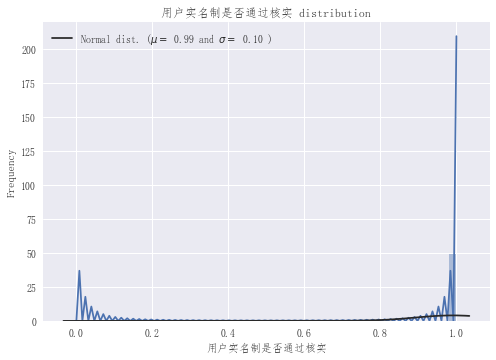

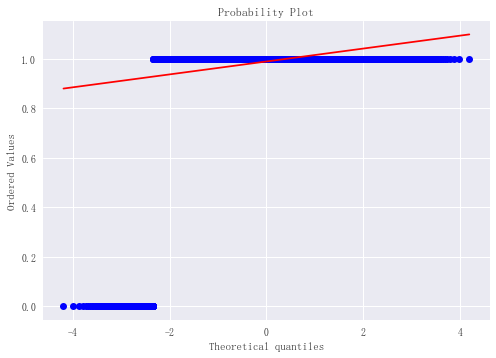


 mu = 37.88 and sigma = 11.61



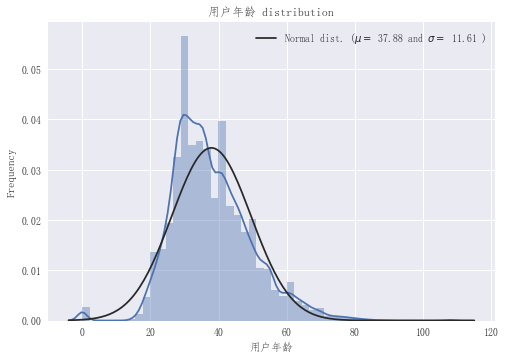

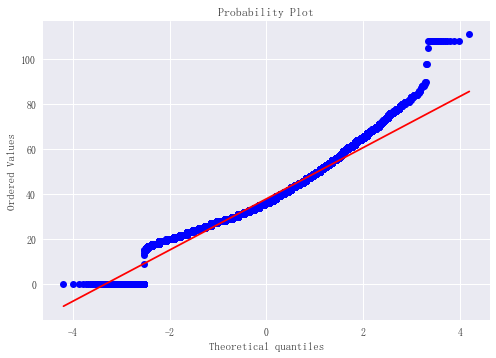


 mu = 0.00 and sigma = 0.06



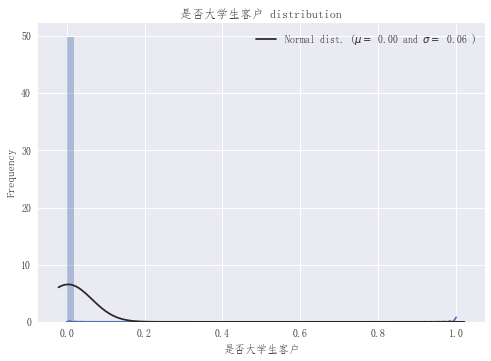

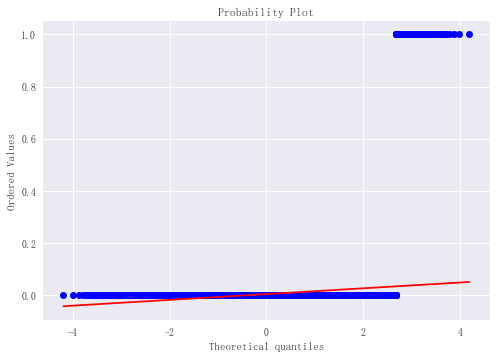


 mu = 0.05 and sigma = 0.22



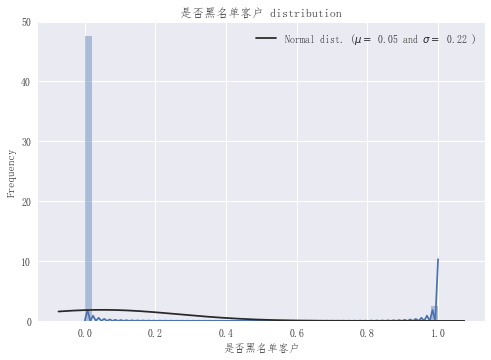

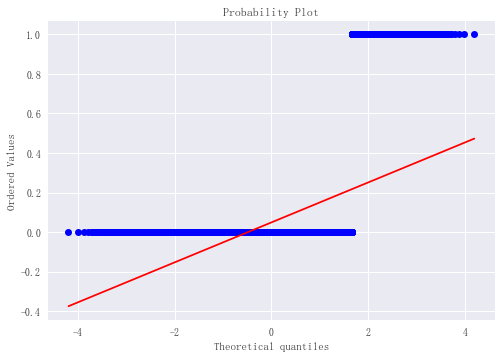


 mu = 0.09 and sigma = 0.28



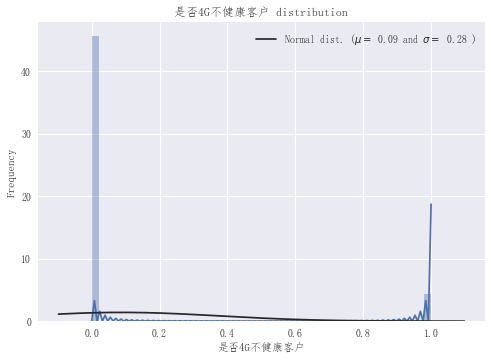

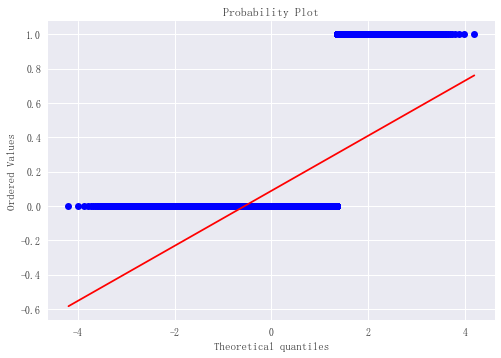


 mu = 96.45 and sigma = 59.18



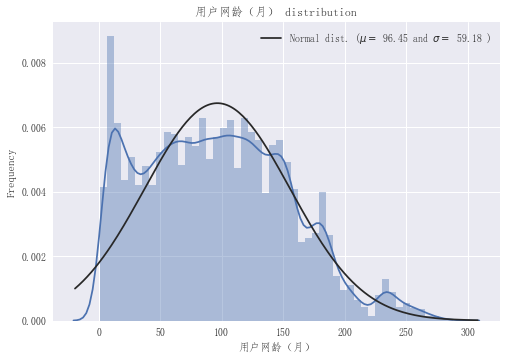

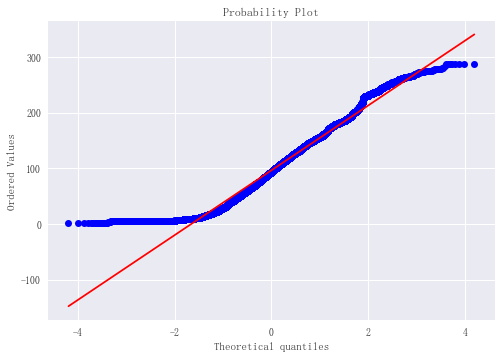


 mu = 0.70 and sigma = 0.46



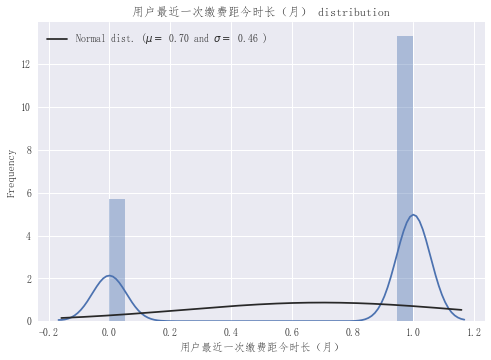

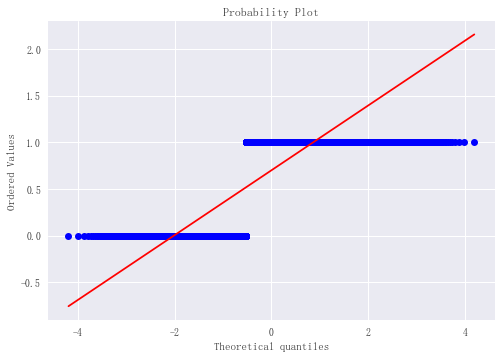


 mu = 53.42 and sigma = 61.81



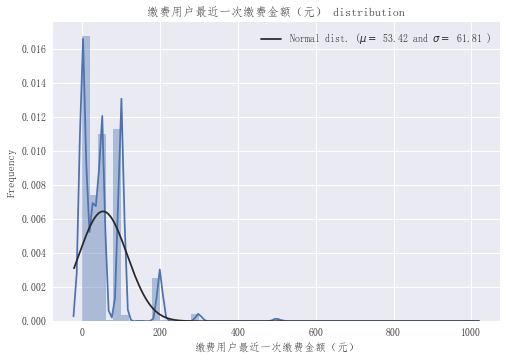

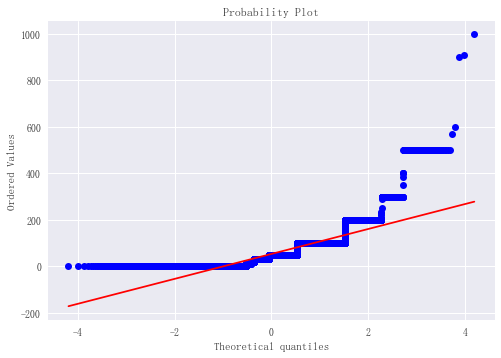


 mu = 98.73 and sigma = 60.76



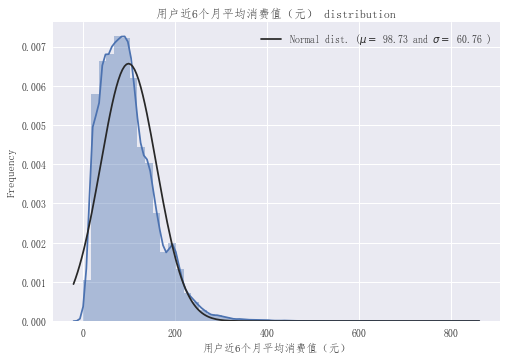

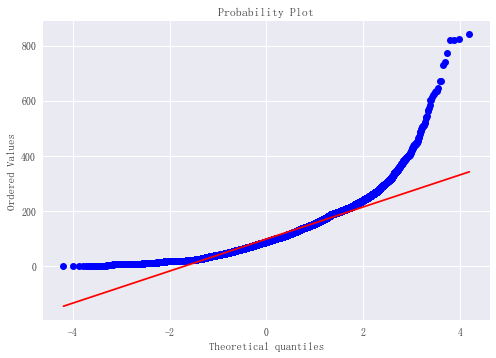


 mu = 99.58 and sigma = 65.33



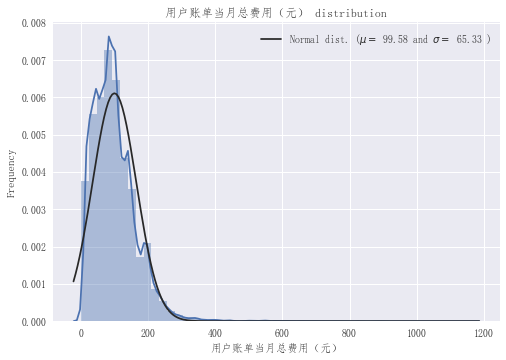

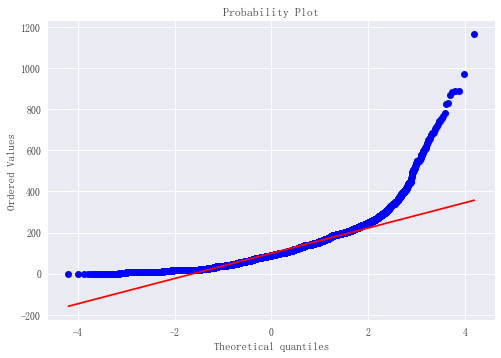


 mu = 114.17 and sigma = 304.06



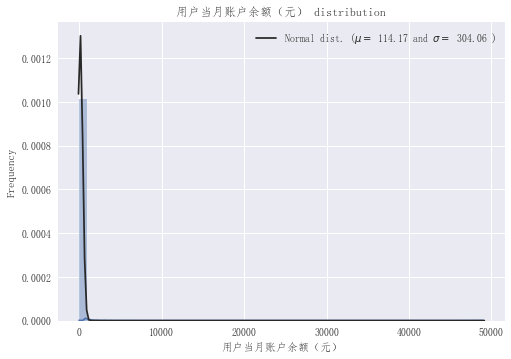

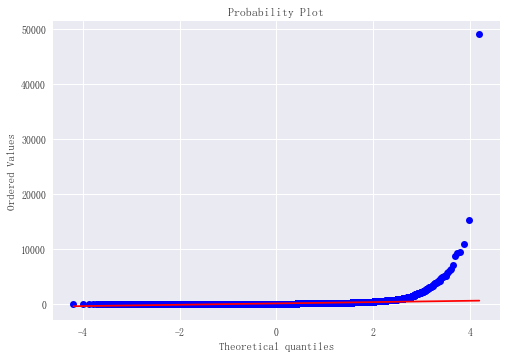


 mu = 0.05 and sigma = 0.22



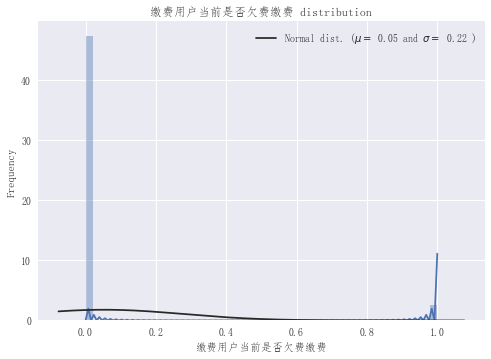

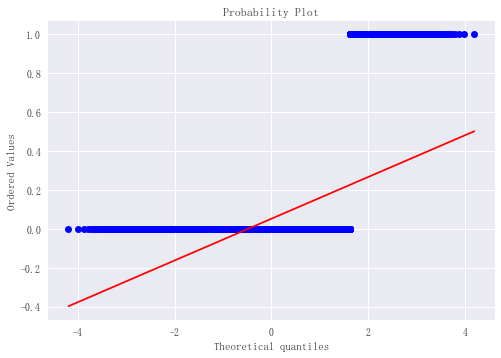


 mu = 3.35 and sigma = 1.24



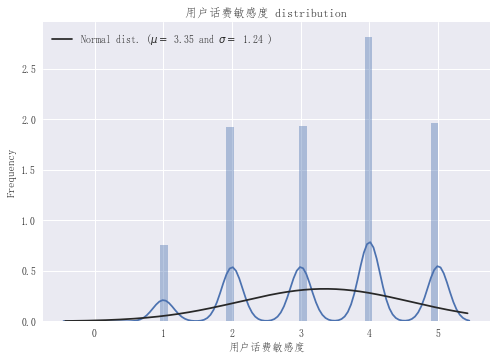

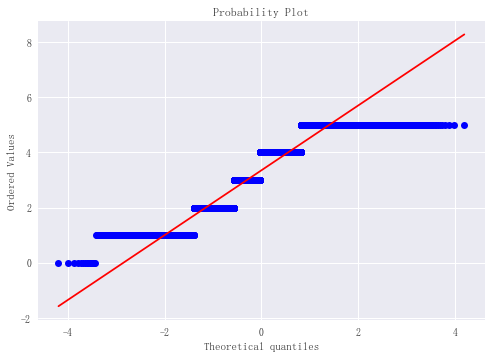


 mu = 48.05 and sigma = 54.21



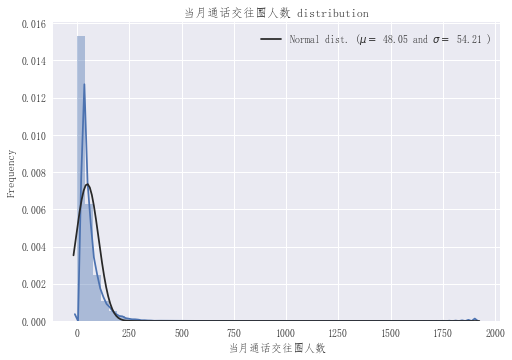

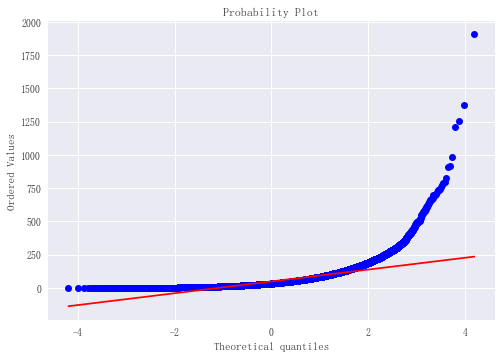


 mu = 0.33 and sigma = 0.47



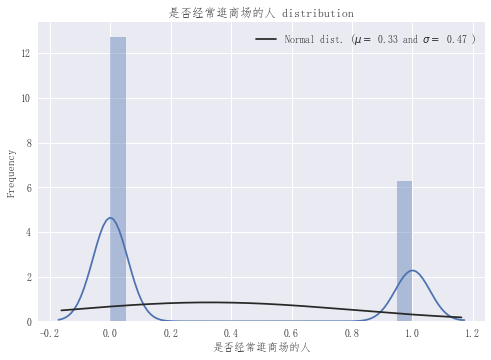

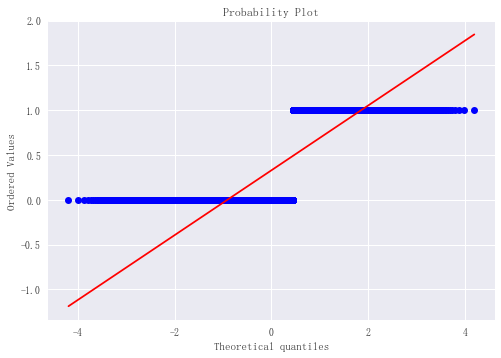


 mu = 26.57 and sigma = 32.79



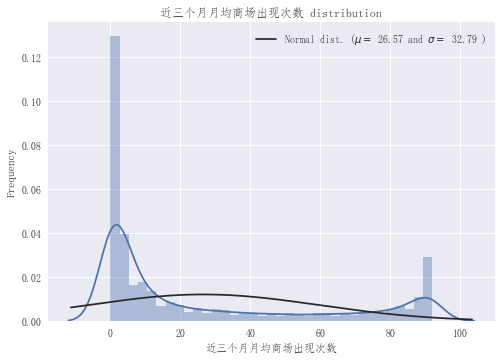

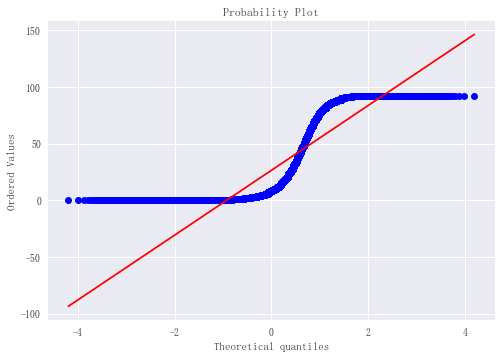


 mu = 0.04 and sigma = 0.19



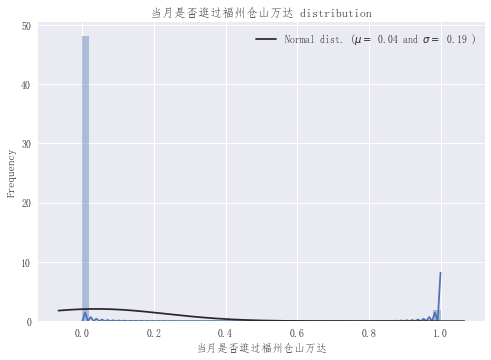

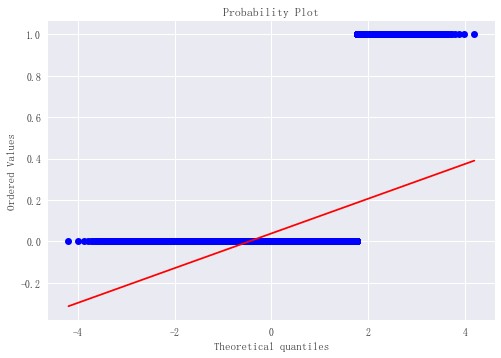


 mu = 0.03 and sigma = 0.16



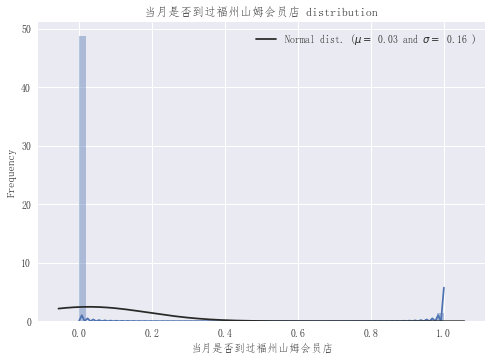

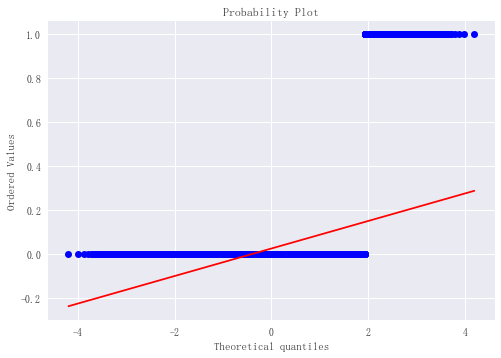


 mu = 0.24 and sigma = 0.43



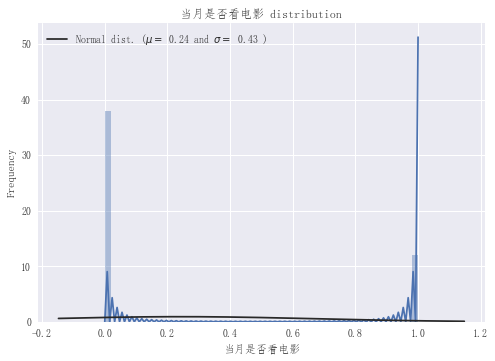

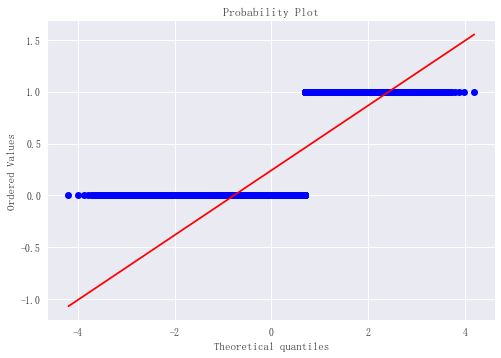


 mu = 0.47 and sigma = 0.50



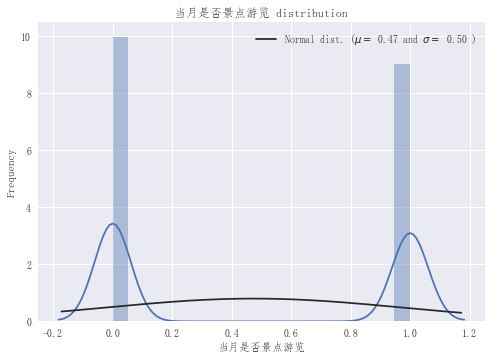

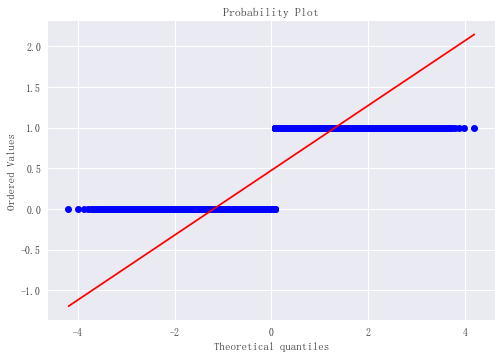


 mu = 0.37 and sigma = 0.48



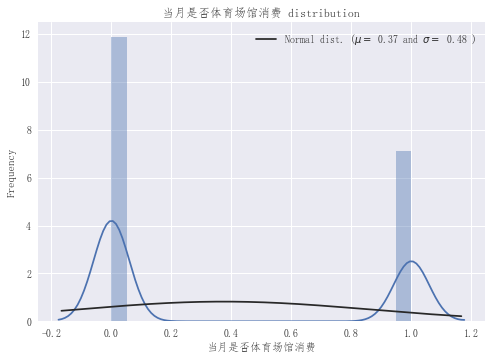

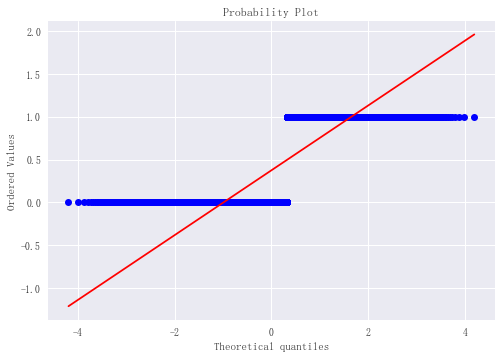


 mu = 1148.82 and sigma = 3992.92



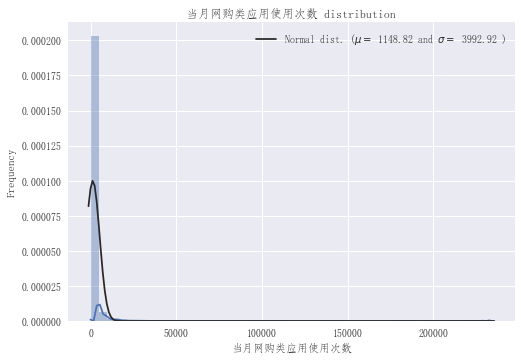

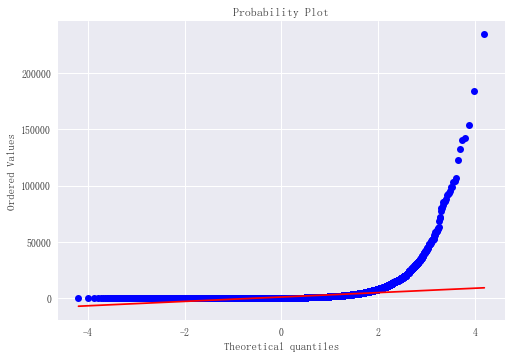


 mu = 1.20 and sigma = 44.47



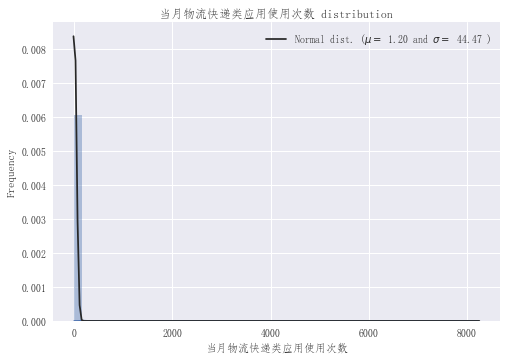

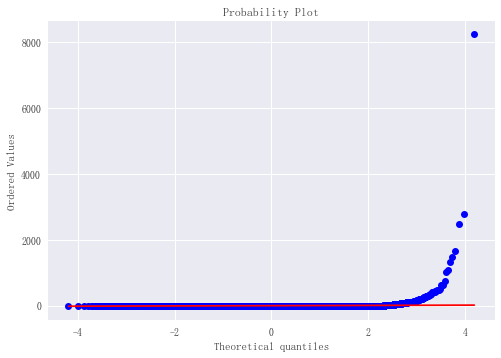


 mu = 971.50 and sigma = 3006.14



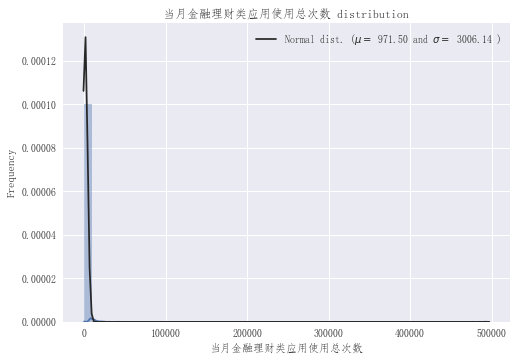

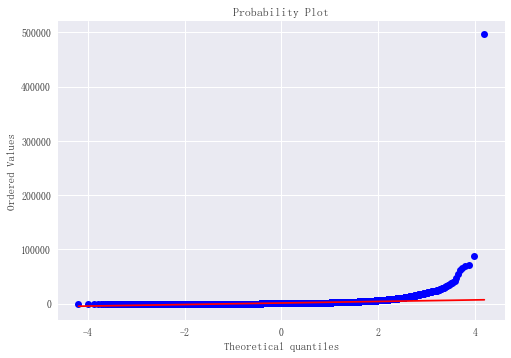


 mu = 3366.52 and sigma = 11509.94



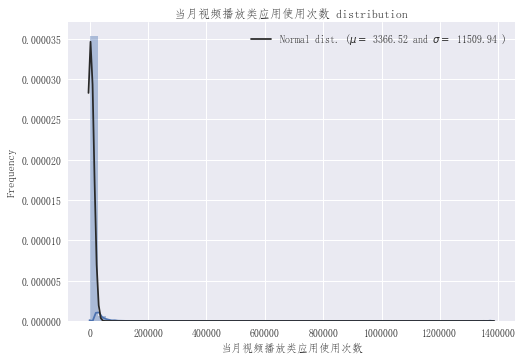

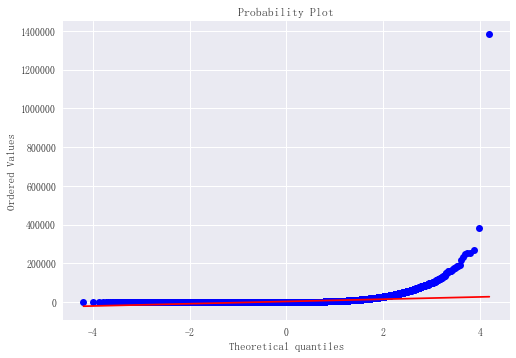


 mu = 0.70 and sigma = 28.72



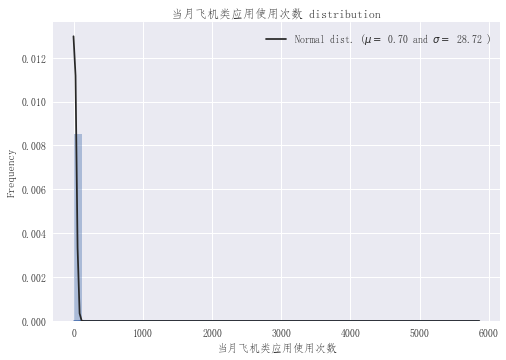

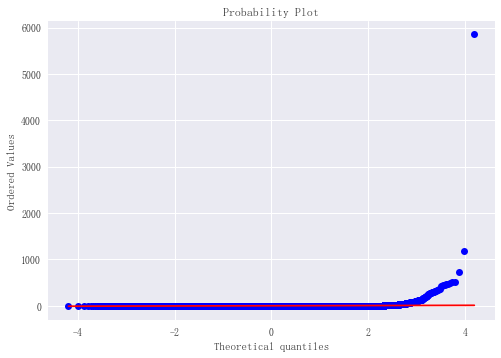


 mu = 0.55 and sigma = 7.74



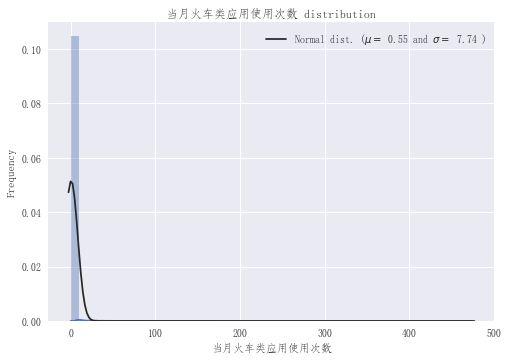

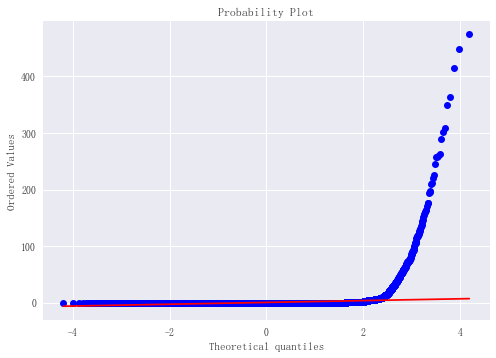


 mu = 19.12 and sigma = 170.07



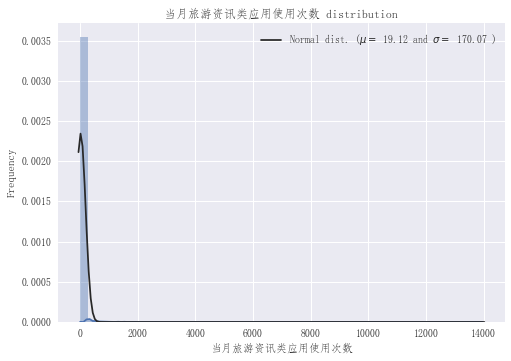

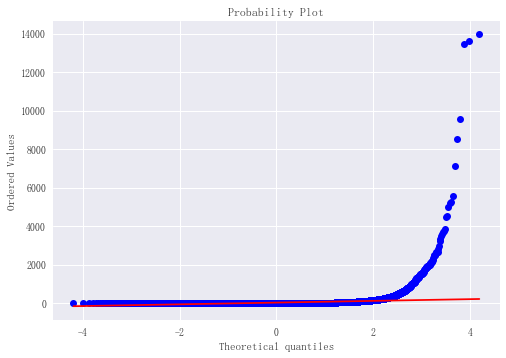


 mu = 618.05 and sigma = 42.44



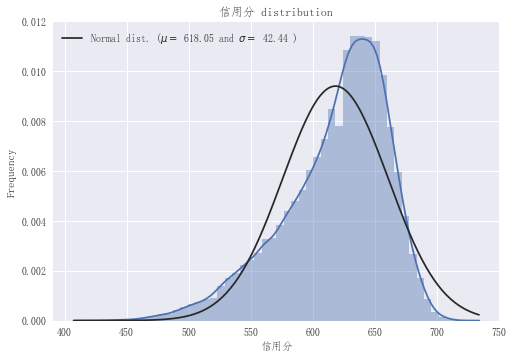

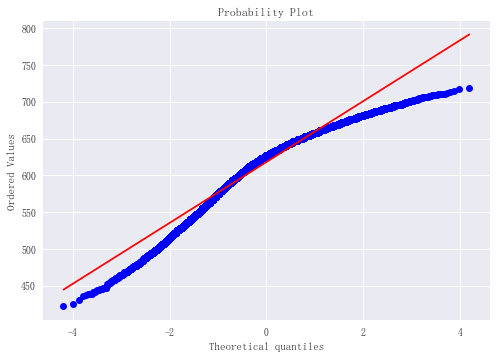

In [8]:
for feature in [i for i in train.columns if i not in['用户编码']]:
    plot_dist(train,feature)

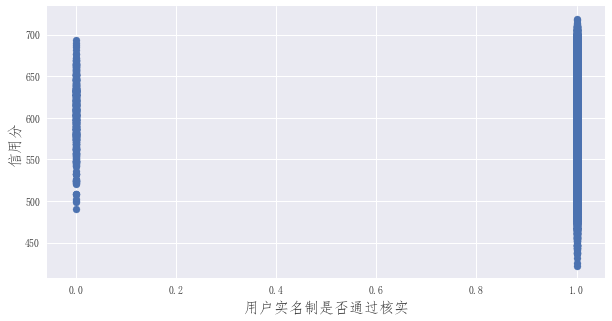

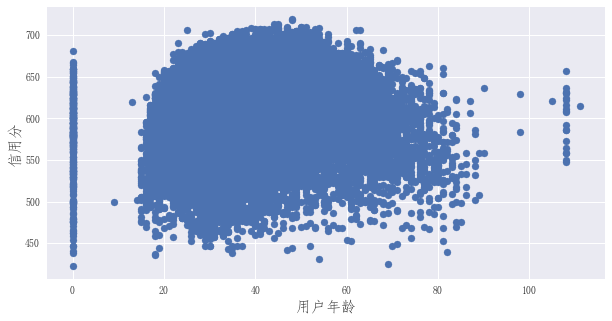

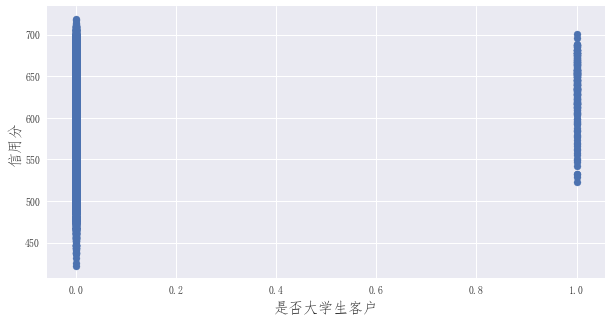

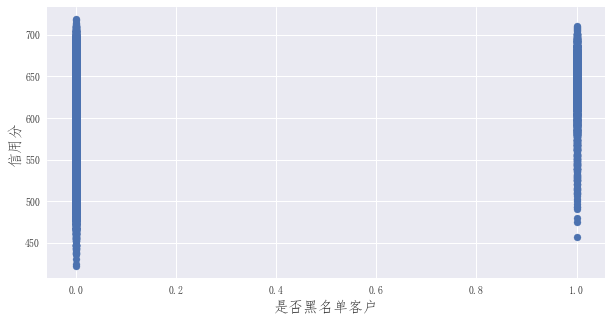

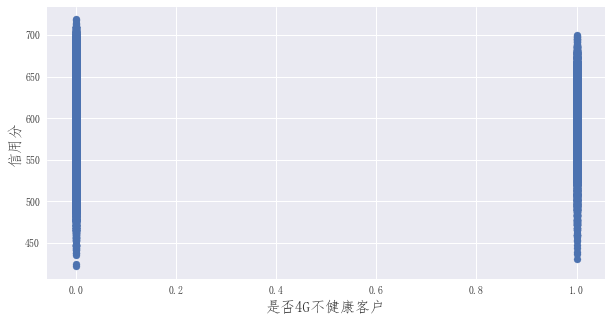

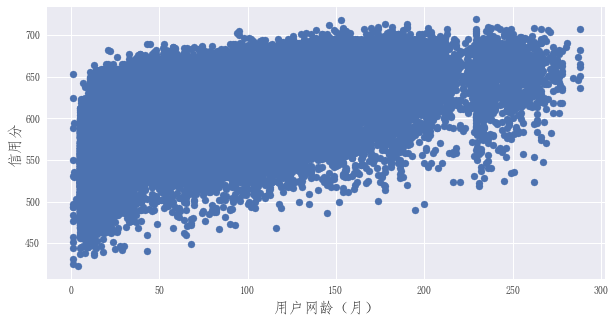

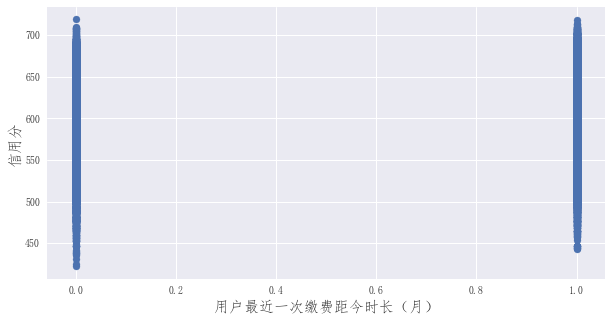

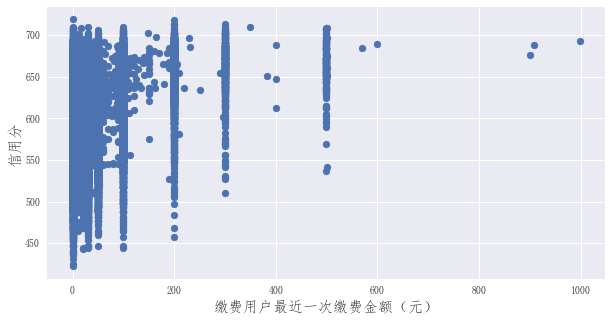

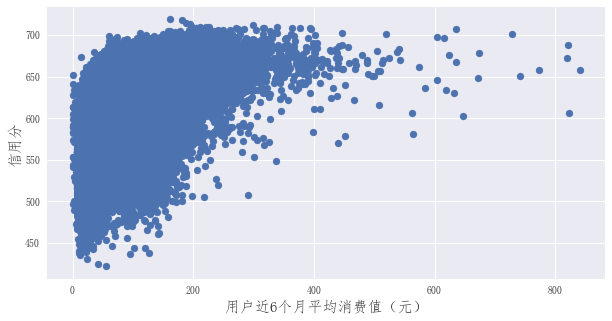

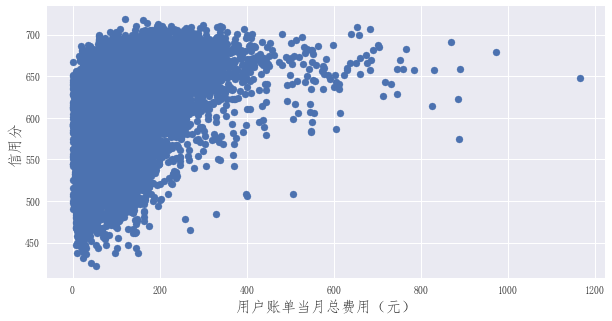

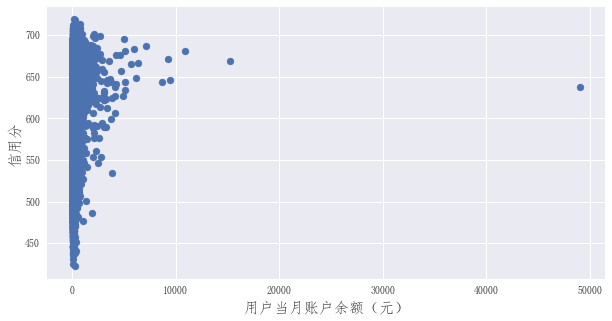

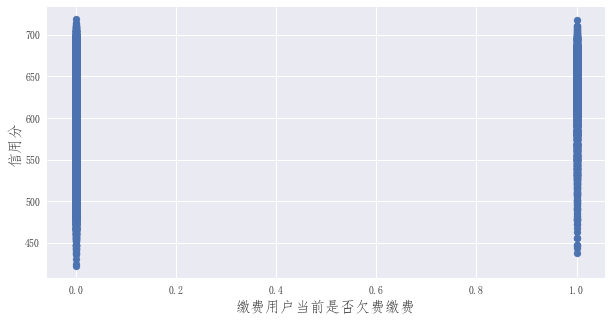

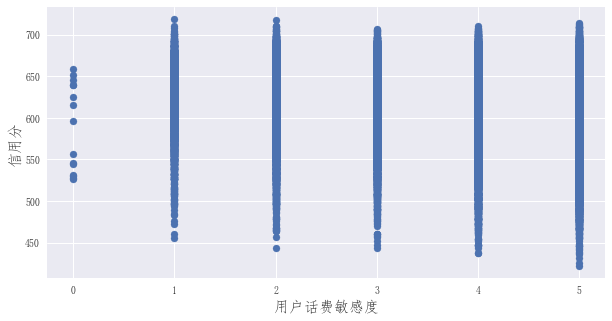

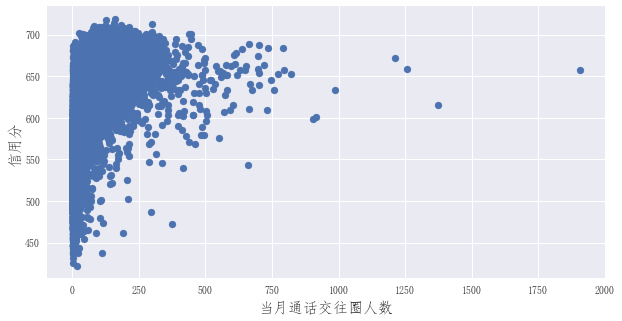

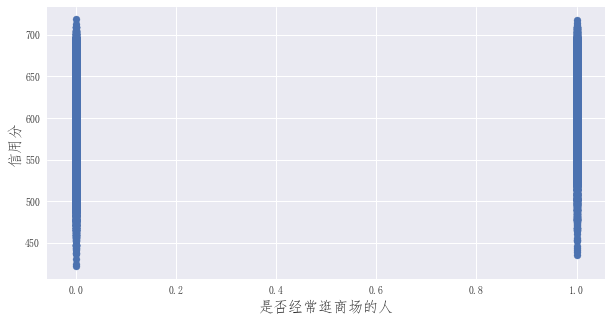

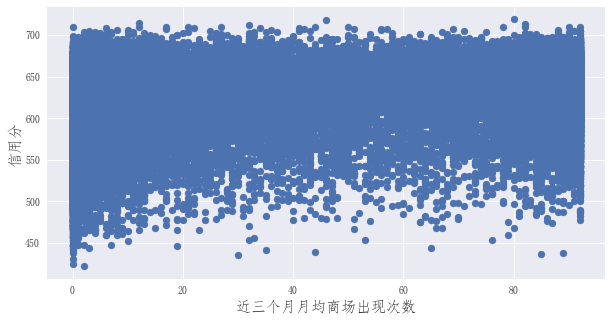

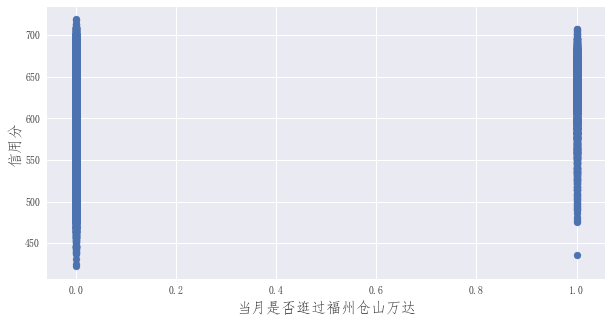

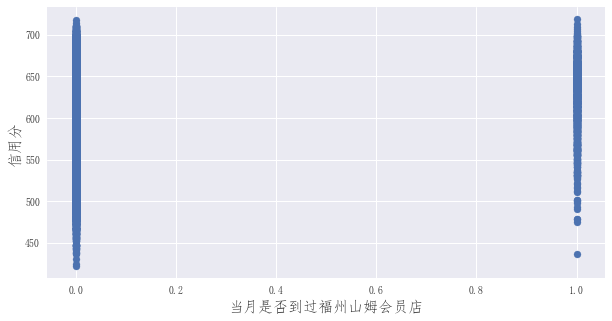

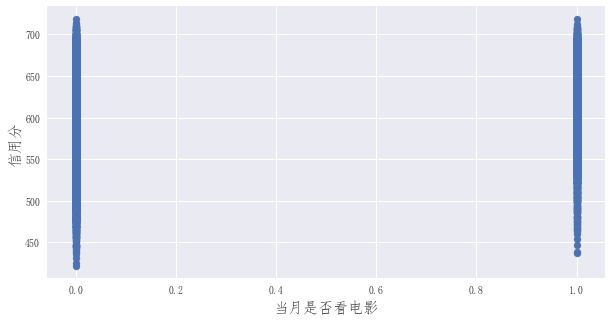

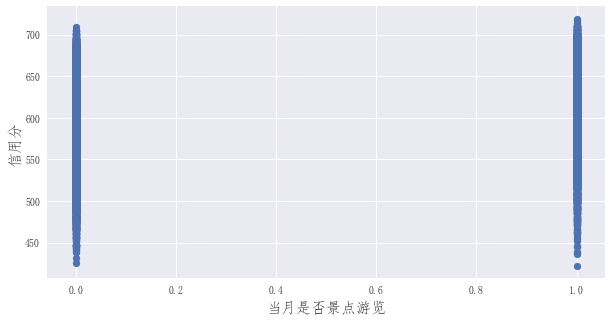

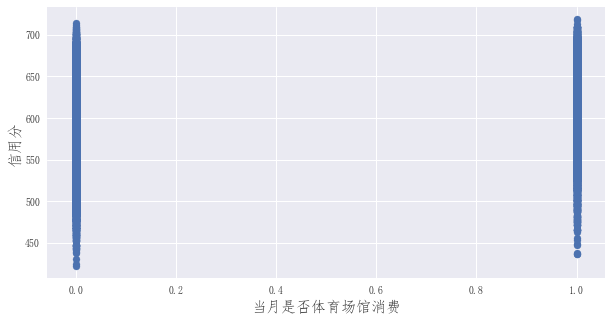

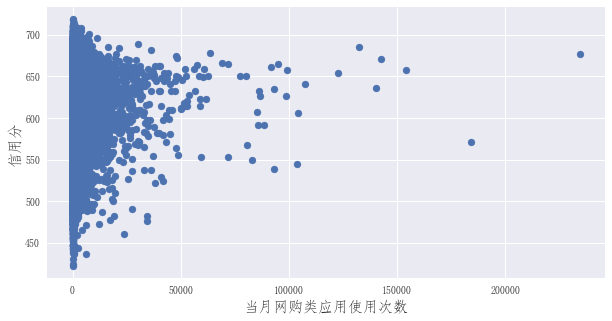

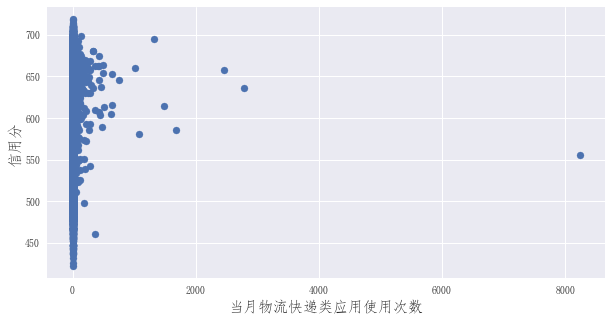

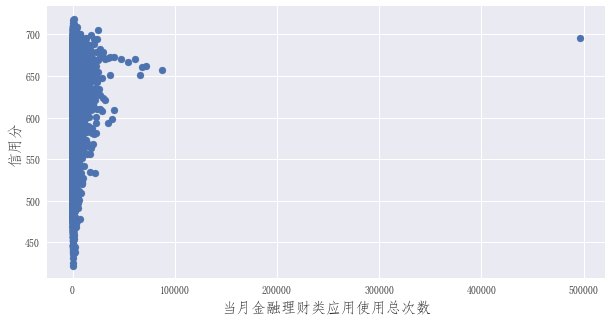

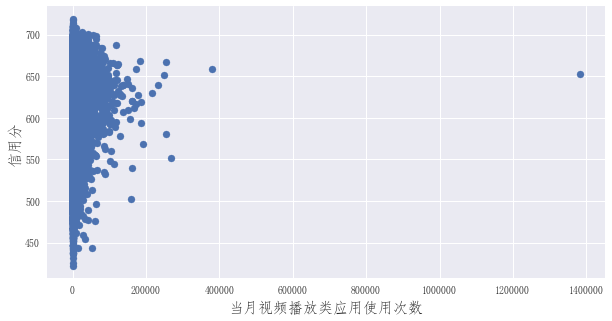

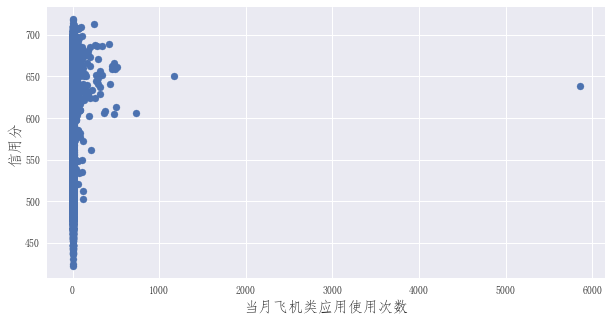

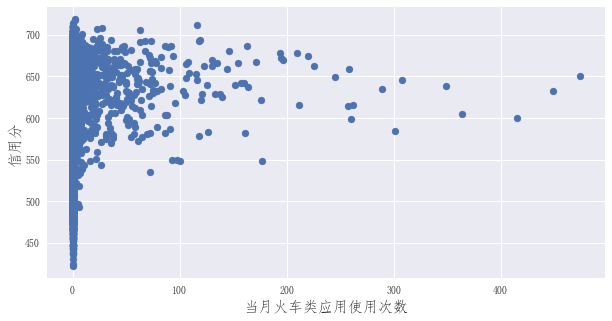

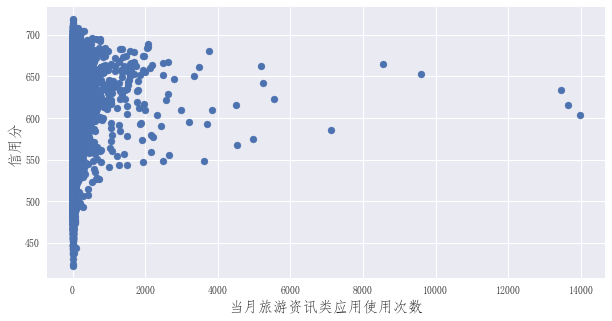

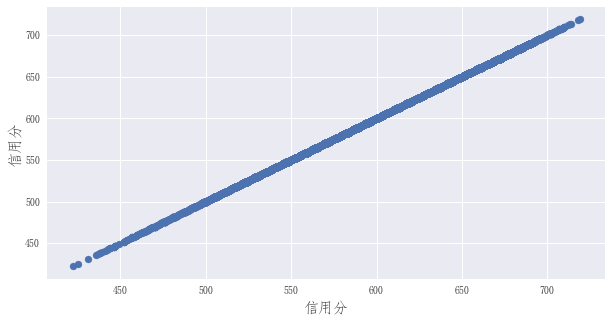

In [9]:
for feature in [i for i in train.columns if i not in['用户编码']]:
    target='信用分'
    plot_corr(train, target, feature)